### **Análise Preditiva**: Minutos ouvidos
#### **Objetivo**: Prever quantos minutos irá ouvir ao longo do tempo. Retornar o histórico real dos últimos 6 meses com a projeção para os próximos 6 meses.

##### Imports

In [109]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

In [110]:
df = pd.read_csv('spotify_songs_bahia.csv')

##### Preparando a base

In [111]:
df_meses = df[['ts', 'ms_played', 'skipped']].copy()
df_meses['ts'] = pd.to_datetime(df_meses['ts'])

df_meses['mes_ano'] = df_meses['ts'].dt.strftime('%m-%Y')

df_meses = (
    df_meses.groupby(['mes_ano'])['ms_played']
    .sum()
    .reset_index()
    )
df_meses['mes_ano'] = pd.to_datetime(df_meses['mes_ano'], format='%m-%Y')

df_meses = df_meses.sort_values('mes_ano').reset_index(drop=True)

df_meses['ms_played'] = df_meses['ms_played'] / 60000

display(df_meses)

,mes_ano,ms_played
0,2025-07-01,2933.212867
1,2025-08-01,5489.308000
2,2025-09-01,5615.847433
3,2025-10-01,711.238267
4,2025-11-01,992.395600
5,2025-12-01,2754.722367
6,2026-01-01,1465.437500


##### Modelo de Previsão (Média Móvel)

In [112]:
df_meses_filtrado = df_meses[df_meses['mes_ano']>= df_meses['mes_ano'].max() - pd.DateOffset(months=6)]
df_meses_filtrado = df_meses_filtrado.reset_index(drop=True)

serie = pd.Series(df_meses_filtrado['ms_played'].values, index=df_meses_filtrado['mes_ano'])

serie = serie.asfreq('MS')

tamanho_serie = len(serie)



medias_movel = serie.rolling(window=2).mean().shift(1)

df_medias_movel = pd.DataFrame({'predicted_ms_played': medias_movel})

df_medias_movel = df_medias_movel.reset_index()

df_medias_movel['mes_ano'] = pd.to_datetime(df_medias_movel['mes_ano'], errors='coerce').dt.strftime('%m-%Y')

display(df_medias_movel)

,mes_ano,predicted_ms_played
0,07-2025,NaN
1,08-2025,NaN
2,09-2025,4211.260433
3,10-2025,5552.577717
4,11-2025,3163.542850
5,12-2025,851.816933
6,01-2026,1873.558983


##### Avaliação do Modelo (MAE)

In [113]:
df_meses_filtrado['mes_ano'] = pd.to_datetime(df_meses_filtrado['mes_ano'])
df_medias_movel['mes_ano'] = pd.to_datetime(df_medias_movel['mes_ano'], format='%m-%Y')

df_erro = pd.merge(df_meses_filtrado, df_medias_movel, on='mes_ano', how='left')

df_erro = df_erro.dropna().reset_index()

valores_reais = df_erro['ms_played']
valores_previstos = df_erro['predicted_ms_played']

mae = mean_absolute_error(valores_reais, valores_previstos)

print(f"Erro Médio Absoluto (MAE): {mae:.2f}")

Erro Médio Absoluto (MAE): 2145.62


##### Previsão para os Próximos 6 Meses

In [114]:
previsoes = {
    'mes_ano': [
        medias_movel.index[-2].strftime('%m-%Y'),
        medias_movel.index[-1].strftime('%m-%Y')
        ], 
    'predicted_ms_played': [
        float(medias_movel.iloc[-2]), 
        float(medias_movel.iloc[-1])
    ]
}




for i in range(1, len(df_meses_filtrado[df_meses_filtrado['mes_ano']<= df_meses_filtrado['mes_ano'].max() + pd.DateOffset(months=6)]) ):
    valor_previsto = (previsoes['predicted_ms_played'][-2] + previsoes['predicted_ms_played'][-1]) / 2 
    proximo_mes = pd.to_datetime(previsoes['mes_ano'][-1], format = '%m-%Y') + pd.DateOffset(months = 1)
    previsoes['predicted_ms_played'].append(valor_previsto)
    previsoes['mes_ano'].append(proximo_mes.strftime('%m-%Y'))

df_previsoes = pd.DataFrame(previsoes)

df_previsoes = df_previsoes.iloc[2:]

# Reseta o índice para ficar bonitinho (0, 1, 2, 3...)
df_previsoes = df_previsoes.reset_index(drop=True)
df_previsoes['mes_ano'] = pd.to_datetime(df_previsoes['mes_ano'], format='%m-%Y')
display(df_previsoes)

,mes_ano,predicted_ms_played
0,2026-02-01,1362.687958
1,2026-03-01,1618.123471
2,2026-04-01,1490.405715
3,2026-05-01,1554.264593
4,2026-06-01,1522.335154
5,2026-07-01,1538.299873


In [115]:
df_previsao_completo = pd.concat([df_medias_movel, df_previsoes])
display(df_previsao_completo)

,mes_ano,predicted_ms_played
0,2025-07-01,NaN
1,2025-08-01,NaN
2,2025-09-01,4211.260433
3,2025-10-01,5552.577717
4,2025-11-01,3163.542850
5,2025-12-01,851.816933
6,2026-01-01,1873.558983
0,2026-02-01,1362.687958
1,2026-03-01,1618.123471
2,2026-04-01,1490.405715


##### Visualização

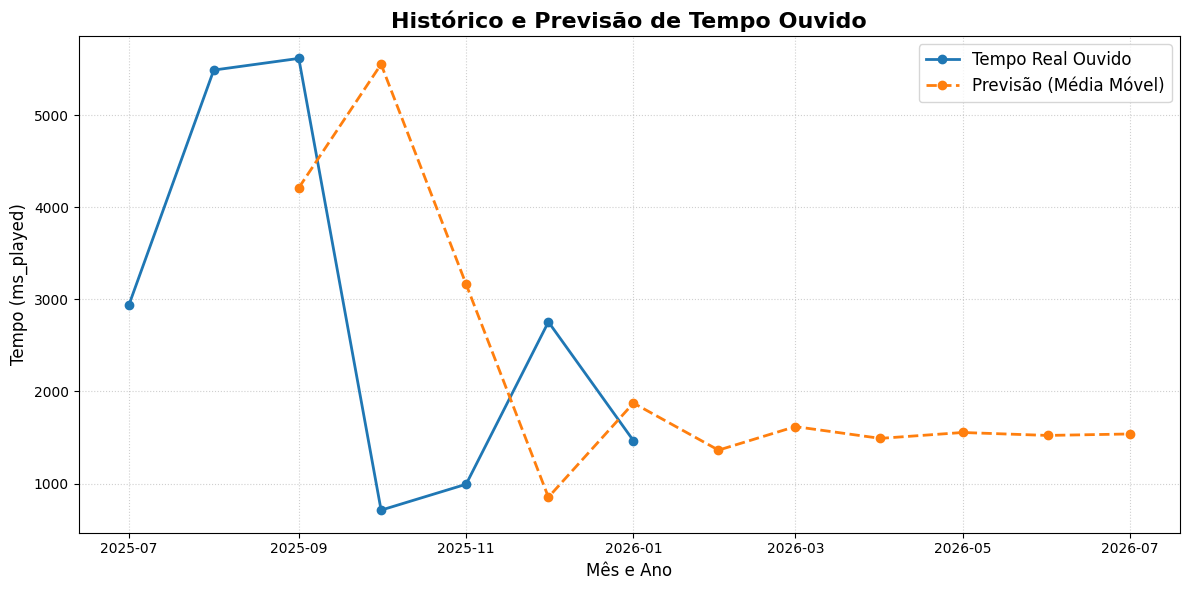

In [ ]:
df_meses['mes_ano'] = pd.to_datetime(df_meses['mes_ano'])
df_previsao_completo['mes_ano'] = pd.to_datetime(df_previsao_completo['mes_ano'])

df_meses = df_meses.sort_values('mes_ano')
df_previsao_completo = df_previsao_completo.sort_values('mes_ano')

plt.figure(figsize=(12, 6))


plt.plot(df_meses['mes_ano'], df_meses['ms_played'], 
         label='Tempo Real Ouvido', color='#1f77b4', marker='o', linewidth=2)


plt.plot(df_previsao_completo['mes_ano'], df_previsao_completo['predicted_ms_played'], 
         label='Previsão (Média Móvel)', color='#ff7f0e', linestyle='--', marker='o', linewidth=2)

plt.title('Histórico e Previsão de Tempo Ouvido', fontsize=16, fontweight='bold')
plt.xlabel('Mês e Ano', fontsize=12)
plt.ylabel('Tempo (ms_played)', fontsize=12)


plt.grid(True, linestyle=':', alpha=0.6) 
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()